本文主要介绍通过DashVector和ModelScope中的Chinese Clip模型实现文搜图、图搜图等功能，同时结合DashText SDK实现sparse vector+dense vector混合检索，熟悉sparse vector的使用方法，提高检索效率。

# 1 准备工作

## 1.1 基本概念
1. Chinese Clip：为CLIP模型的中文版本，使用大规模中文数据进行训练（~2亿图文对），可用于图文检索和图像、文本的表征提取，应用于搜索、推荐等应用场景。详情请参考：https://modelscope.cn/models/iic/multi-modal_clip-vit-huge-patch14_zh/summary
2. DashVector：向量检索服务基于阿里云自研的向量引擎 Proxima 内核，提供具备水平拓展、全托管、云原生的高效向量检索服务。向量检索服务将强大的向量管理、查询等能力，通过简洁易用的 SDK/API 接口透出，方便在大模型知识库搭建、多模态 AI 搜索等多种应用场景上集成。详情请参考：https://www.aliyun.com/product/ai/dashvector
3. MUGE数据集：MUGE（牧歌，Multimodal Understanding and Generation Evaluation）是业界首个大规模中文多模态评测基准，由达摩院联合浙江大学、阿里云天池平台联合发布，中国计算机学会计算机视觉专委会（CCF-CV专委）协助推出。目前包括： · 包含多模态理解与生成任务在内的多模态评测基准，其中包括图像描述、图文检索以及基于文本的图像生成。未来我们将公布更多任务及数据。 · 公开的评测榜单，帮助研究人员评估模型和追踪进展。 MUGE旨在推动多模态表示学习进展，尤其关注多模态预训练。具备多模态理解和生成能力的模型均可以参加此评测，欢迎各位与我们共同推动多模态领域发展。详情请参考：https://modelscope.cn/datasets/modelscope/muge/summary
4. DashText：是向量检索服务DashVector推荐使用的稀疏向量编码器（Sparse Vector Encoder），DashText可通过BM25算法将原始文本转换为稀疏向量（Sparse Vector）表达，通过DashText可大幅度简化使用DashVector关键词感知检索能力。详情请参考：https://help.aliyun.com/document_detail/2546039.html

## 1.2 准备工作
1. 获取DashVector的API-KEY。API-KEY用于访问DashVector服务，详请参考：https://help.aliyun.com/document_detail/2510230.html
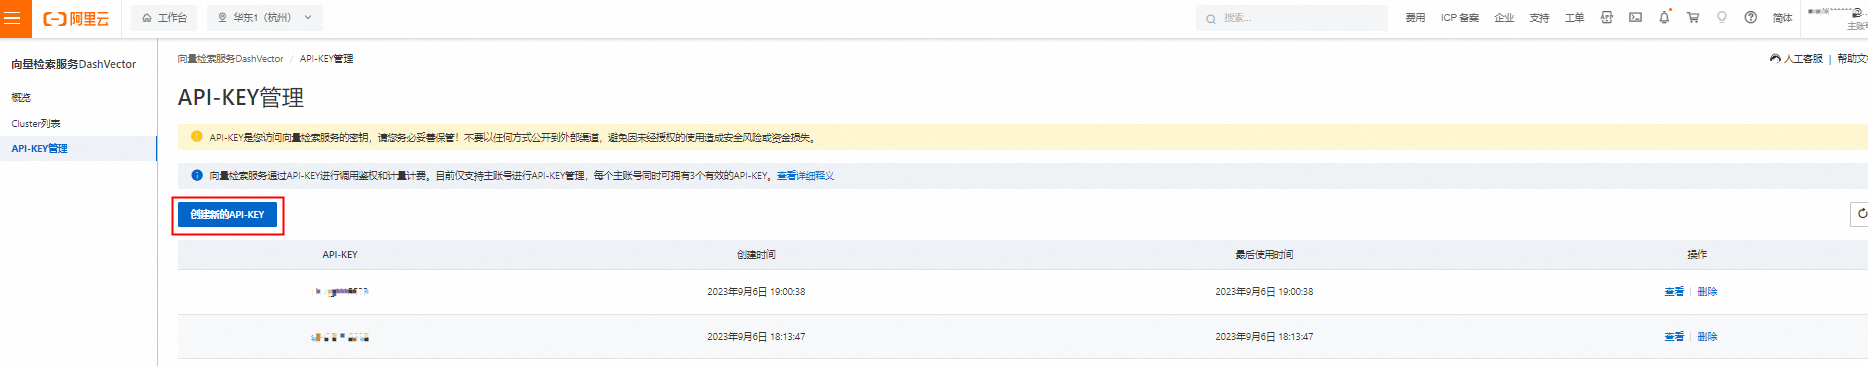

2. 申请DashVector测试实例，DashVector提供免费试用实例，可以薅一波。详情请见：https://help.aliyun.com/document_detail/2568083.html
3. 获取DashVector实例的endpoint，endpoint用于访问DashVector具体的实例。详情请见：https://help.aliyun.com/document_detail/2568084.html
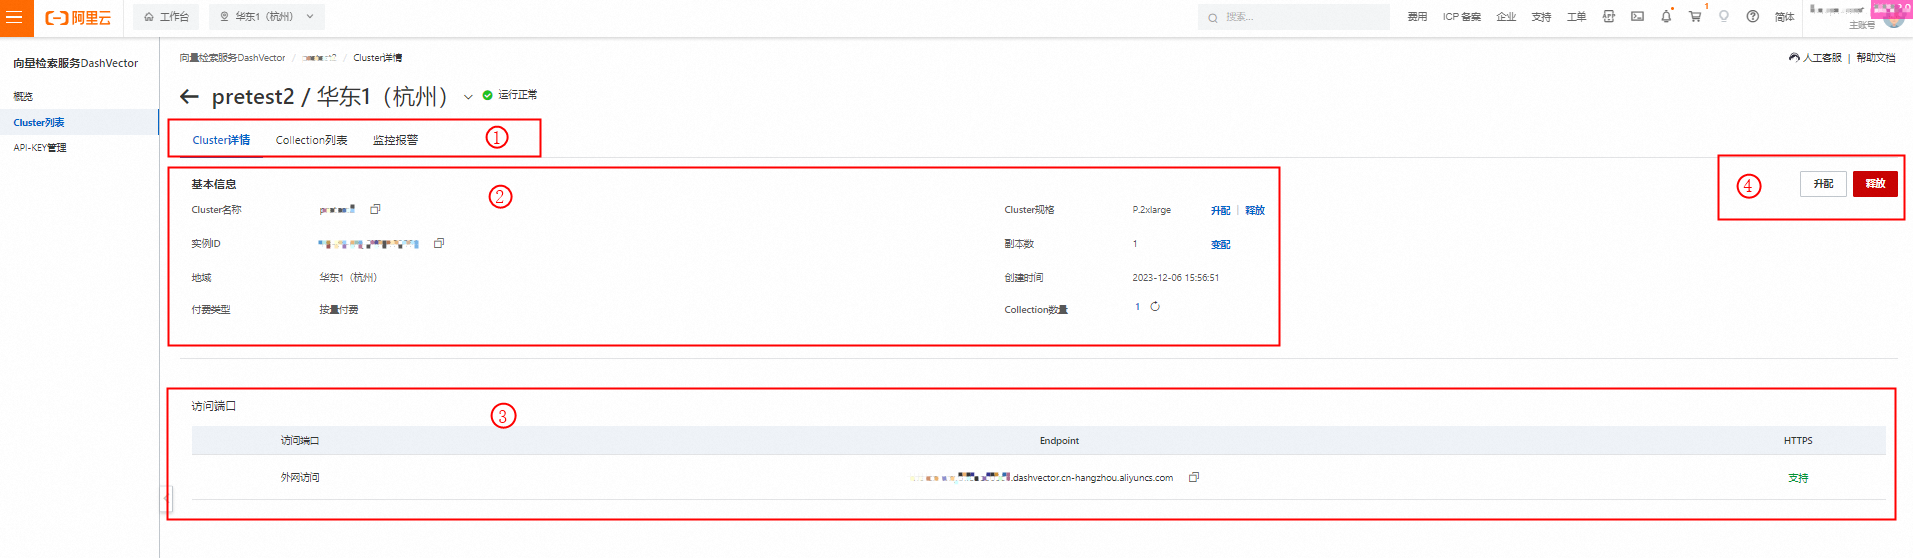

4. 安装DashVector、DashText、ModelScope的SDK

In [ ]:
!pip install dashvector
!pip install dashtext
!pip install modelscope

由于安装ModelScope SDK需要一些依赖，继续安装，安装的时间有点长，请耐心等待~~~~~

In [ ]:
!pip install decord
!pip install torch torchvision opencv-python timm librosa fairseq transformers unicodedata2 zhconv rapidfuzz

由于本教程中，会使用DashText的sdk生成稀疏向量，生成稀疏向量过程中会先下载一个词包，下载过程比较长。所以可以预先下载。

In [ ]:
!wget https: // dashvector-data.oss-cn-beijing.aliyuncs.com/public/sparsevector/bm25_zh_default.json

## 1.3 多模态搜索过程
1. 多模态搜索分为两个过程，即索引过程和搜索过程。
2. 索引过程：本教程在索引过程中，使用MUGE数据集，数据格式如下。只需要对MUGE数据集中的图片和文本提取特征，然后将特征插入到DashVector中，就完成了索引过程。


```
[{
    "query_id": "54372",
    "query": "金属产品打印",
    "image_id": "813904",
    "image": <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224 at 0x7F8EB1F39DB0>
},
{
    "query_id": "78633",
    "query": "夹棉帽子",
    "image_id": "749842",
    "image": <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224 at 0x7F8EB0AFFF70>
}]
```
3. 搜索过程：通过对输入的文本或者图片，提取特征，并通过特征在DashVector中已经索引的向量中进行相似向量查询，并将查询后的结果解析成可视化的图片和文本，即完成了搜索过程。详情请看下图。

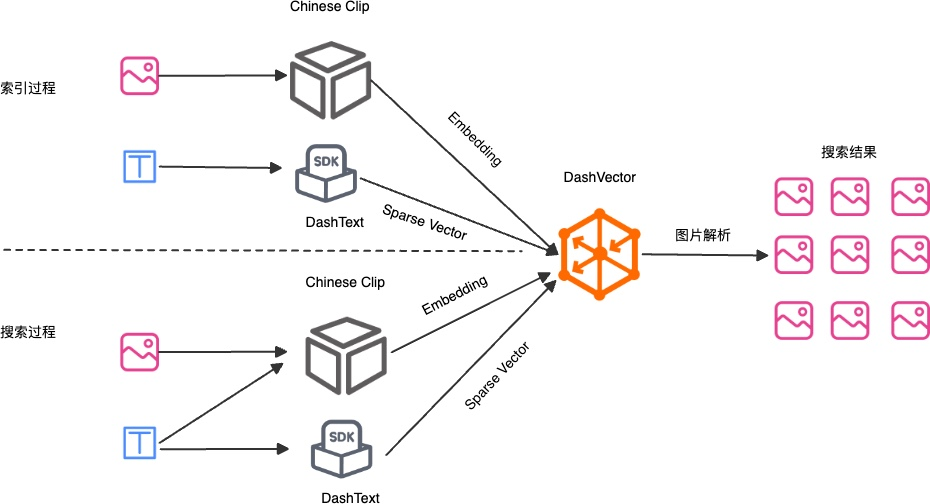


# 2 创建DashVector Collection

In [ ]:
from dashvector import Client

# 如下填写您在1.2 准备工作中获取的DashVector API-KEY
DASHVECTOR_API_KEY = '{YOUR DashVector API-KEY}'
# 如下填写您在1.2 准备工作中获取的DashVector中Cluster中的Endpoint
DASHVECTOR_END_POINT = '{YOUR DashVector Endpoint}'

# 初始化DashVector 的client
client = Client(api_key=DASHVECTOR_API_KEY, endpoint=DASHVECTOR_END_POINT)

response = client.create(
    # Collection的名称，名称可自定义。这里暂时定义为：ImageTextSearch
    name='ImageTextSearch',
    # 创建Collection的维度，注意一定是1024维。因为后面我们会使用Chinese Clip模型进行embedding，Chinese Clip模型的输出维度是1024维。
    dimension=1024,
    # 距离度量方式一定为dotproduct，因为稀疏向量只支持dotproduc这种度量方式。
    metric='dotproduct',
    dtype=float,
    # 定义schema，通过schema可以定义Collection中包含哪些字段，以及字段的类型，以便实现更快速的搜索。这里定义了image_id、query和query_id三个schema。
    # 关于Schema的详细使用请参考：https://help.aliyun.com/document_detail/2510228.html
    fields_schema={'image_id': int, 'query': str, 'query_id': int}
)

print(response)



好啦，Collection创建成功了。
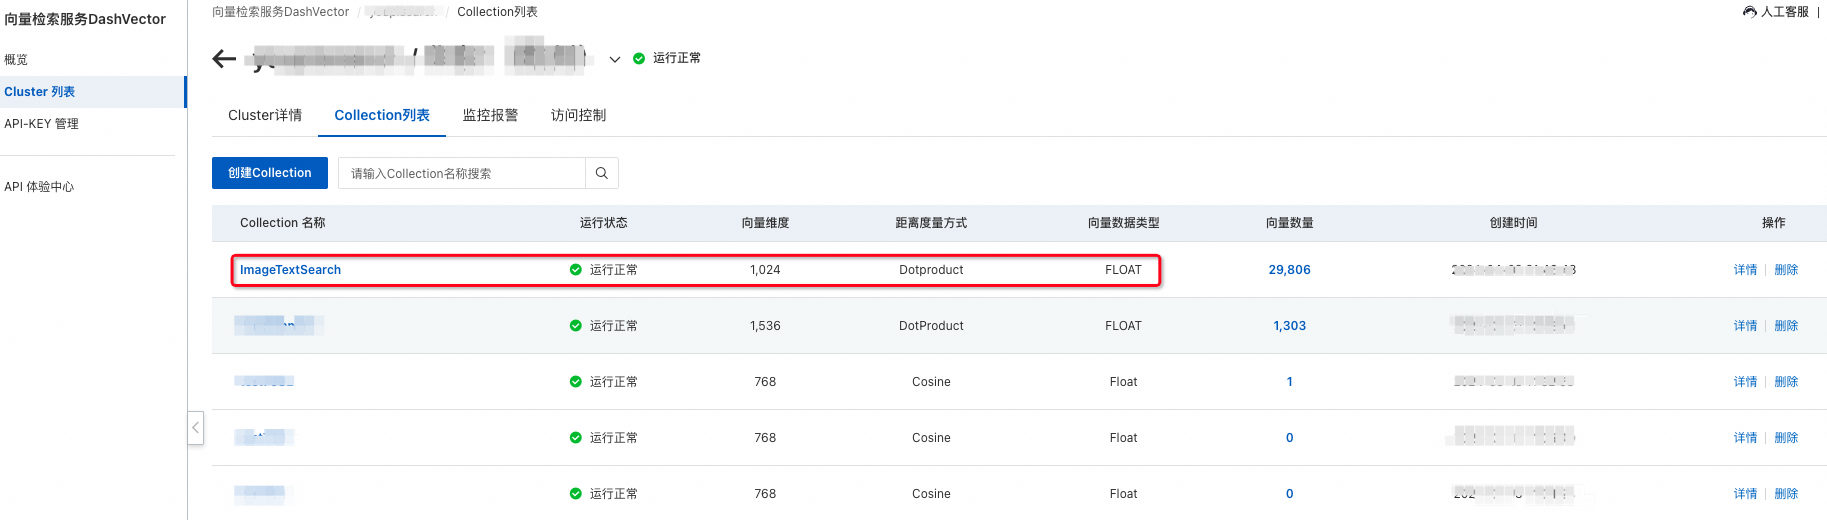

# 3 图片和文本索引
1. 图片和文本插入，由于涉及到图片特征提取，所以速度会有点慢，建议使用GPU进行特征提取。

In [ ]:
# 首先import一大堆东西
from modelscope.msdatasets import MsDataset
from modelscope.utils.constant import Tasks
from modelscope.pipelines import pipeline
import base64
import io
from dashvector import Client, Doc, DashVectorCode, DashVectorException
from dashtext import SparseVectorEncoder



In [ ]:
# load 数据集,选取modelscope中的muge数据集，取数据集中validation部分
# muge数据集的格式为：
# [{
#     "query_id": "54372",
#     "query": "金属产品打印",
#     "image_id": "813904",
#     "image": <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224 at 0x7F8EB1F39DB0>
# },
# {
#     "query_id": "78633",
#     "query": "夹棉帽子",
#     "image_id": "749842",
#     "image": <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224 at 0x7F8EB0AFFF70>
# }]
# 首次load muge数据集有点慢，请耐心等待。
datasets = MsDataset.load("muge", split="validation")
# 获取数据集的长度，也就是数据集中有多少个这样的数据
datasets_len = len(datasets)

# 初始化ModelScope推理pipeline，本教程使用Chinese Clip作为embedding模型。由于图片的Embedding比较消耗计算资源，所以推荐使用GPU进行推理加速。
# 请参考：https://modelscope.cn/models/iic/multi-modal_clip-vit-huge-patch14_zh/summary
pipeline = pipeline(task=Tasks.multi_modal_embedding,
                    model='damo/multi-modal_clip-vit-huge-patch14_zh', model_revision='v1.0.0')



In [ ]:
# 初始化稀疏向量编码器，用于对muge数据集中的query进行稀疏向量编码，中文编码。详情请参考：https://help.aliyun.com/document_detail/2546039.html
encoder = SparseVectorEncoder()
# encoder初始化的时间比较长，主要原因在于稀疏向量编码器需要加载一个json文件，该文件比较大，需要下载。我们可以先下载完，保存在本地，直接加载，速度会快很多。
# 下载链接：https://dashvector-data.oss-cn-beijing.aliyuncs.com/public/sparsevector/bm25_zh_default.json
# 也可以使用：wget https://dashvector-data.oss-cn-beijing.aliyuncs.com/public/sparsevector/bm25_zh_default.json，直接下载到本地。
# 下载完成后，放在本机目录中，本教程已经下载完成，放在根目录下。
encoder_path = 'bm25_zh_default.json'
encoder.load(encoder_path)



In [ ]:
# 如下填写您在1.2 准备工作中获取的DashVector API-KEY
DASHVECTOR_API_KEY = '{YOUR DashVector API-KEY}'
# 如下填写您在1.2 准备工作中获取的DashVector中Cluster中的Endpoint
DASHVECTOR_END_POINT = '{YOUR DashVector Endpoint}'

# 初始化dashvector的Client，用于访问dashvector服务
# 请参考：https://help.aliyun.com/document_detail/2510240.html
client = Client(api_key=DASHVECTOR_API_KEY, endpoint=DASHVECTOR_END_POINT)




In [ ]:
# 将图片转成字符串，用于将图片存储在dashvector中
def image_to_str(image):
    image_byte_arr = io.BytesIO()
    image.save(image_byte_arr, format='PNG')
    image_bytes = image_byte_arr.getvalue()
    return base64.b64encode(image_bytes).decode()


# 通过Chinese Clip提取图片特征，并转成向量
def image_vector(image):
    # 通过Chinese Clip提取图片特征，返回为一个tensor
    img_embedding = pipeline.forward({'img': image})['img_embedding']
    # 将返回的tensor转成向量,向量需要转存到cpu中
    img_vector = img_embedding.detach().cpu().numpy()
    return img_vector if isinstance(image, list) else img_vector[0]


# 通过Chinese Clip提取文本特征，并转成向量
def text_vector(text):
    # 通过Chinese Clip提取文本特征，返回为一个tensor
    text_embedding = pipeline.forward({'text': text})['text_embedding']
    # 将返回的tensor转成向量,向量需要转存到cpu中
    text_vector = text_embedding.detach().cpu().numpy()
    return text_vector if isinstance(text, list) else text_vector[0]


# 通过dashtext对文本生成稀疏向量。注意，本函数为生成入库的稀疏向量，而不是query的稀疏向量
def sparse_vector_documents(text):
    # 通过dashtext生成稀疏向量
    sparse_vector = encoder.encode_documents(text)
    return sparse_vector if isinstance(text, list) else sparse_vector


# 插入向量数据，batch_size默认为10，最大不超过20
def insert_docs(collection_name: str, partition='default', batch_size=10):
    idx = 0
    while idx < datasets_len:
        # 获取batch range数据
        batch_range = range(idx, idx + batch_size) if idx + batch_size < datasets_len else range(idx, datasets_len)

        # 获取image信息
        images = [datasets[i]['image'] for i in batch_range]
        # 通过Chinese Clip提取图片特征，返回为一个vector
        images_vector = image_vector(images)

        # 获取query信息
        texts = [datasets[i]['query'] for i in batch_range]
        # 生成稀疏向量
        documents_sparse_vector = sparse_vector_documents(texts)

        # 获取图片ID和query ID
        images_ids = [datasets[i]['image_id'] for i in batch_range]
        query_ids = [datasets[i]['query_id'] for i in batch_range]

        # 获取Collection
        collection = client.get(collection_name)
        # 批量插入
        response = collection.upsert(
            [
                Doc(
                    id=image_id,
                    vector=img_vector,
                    sparse_vector=document_sparse_vector,
                    fields={
                        # 由于在创建Collection时，image_id和query_id都是int类型，所以这里需要转换为int类型
                        'image_id': int(image_id),
                        'query_id': int(query_id),
                        'query': query,
                        # 将Image格式转成字符串，用于存储在dashvector中
                        'image': image_to_str(image)
                    }
                ) for img_vector, document_sparse_vector, image_id, query_id, image, query in
                zip(images_vector, documents_sparse_vector, images_ids, query_ids, images, texts)
            ]
        )
        print(response)
        idx += batch_size

    return response



In [ ]:
if __name__ == '__main__':
    # 插入数据，batch_size最大20
    response = insert_docs(collection_name='ImageTextSearch', batch_size=20)



2. 向量插入后，就可以在DashVector控制台看到向量啦！https://dashvector.console.aliyun.com/cn-hangzhou/cluster/

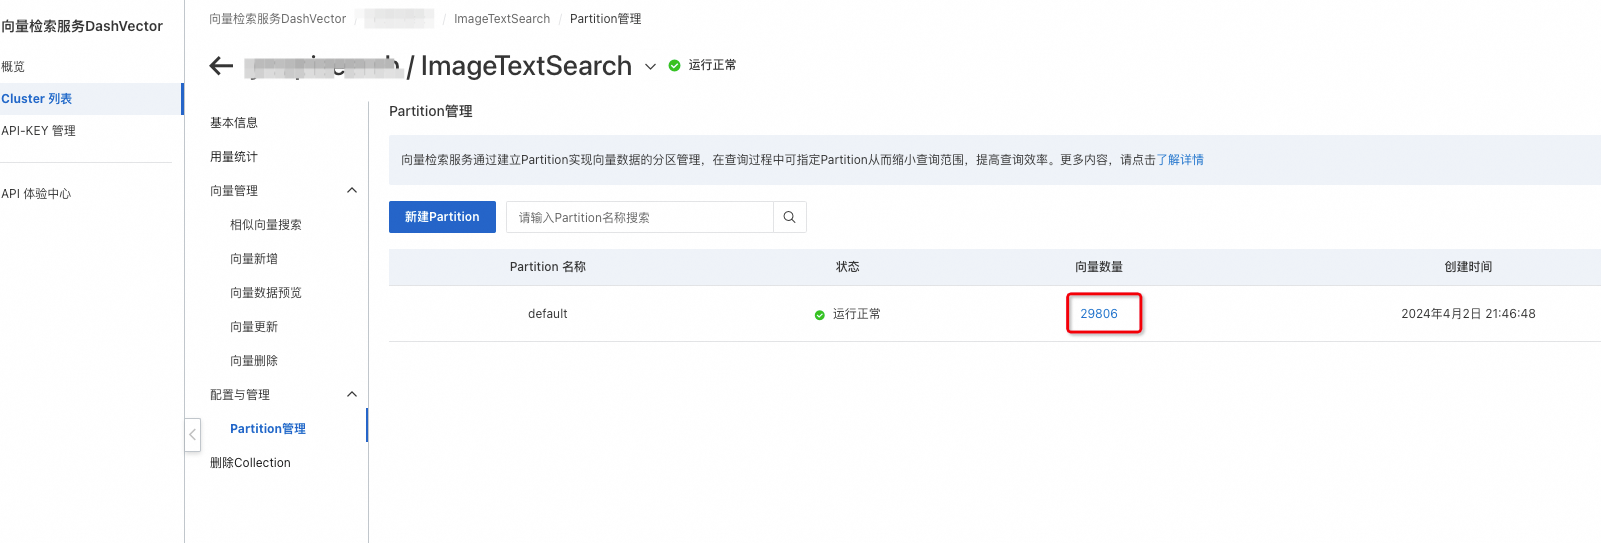


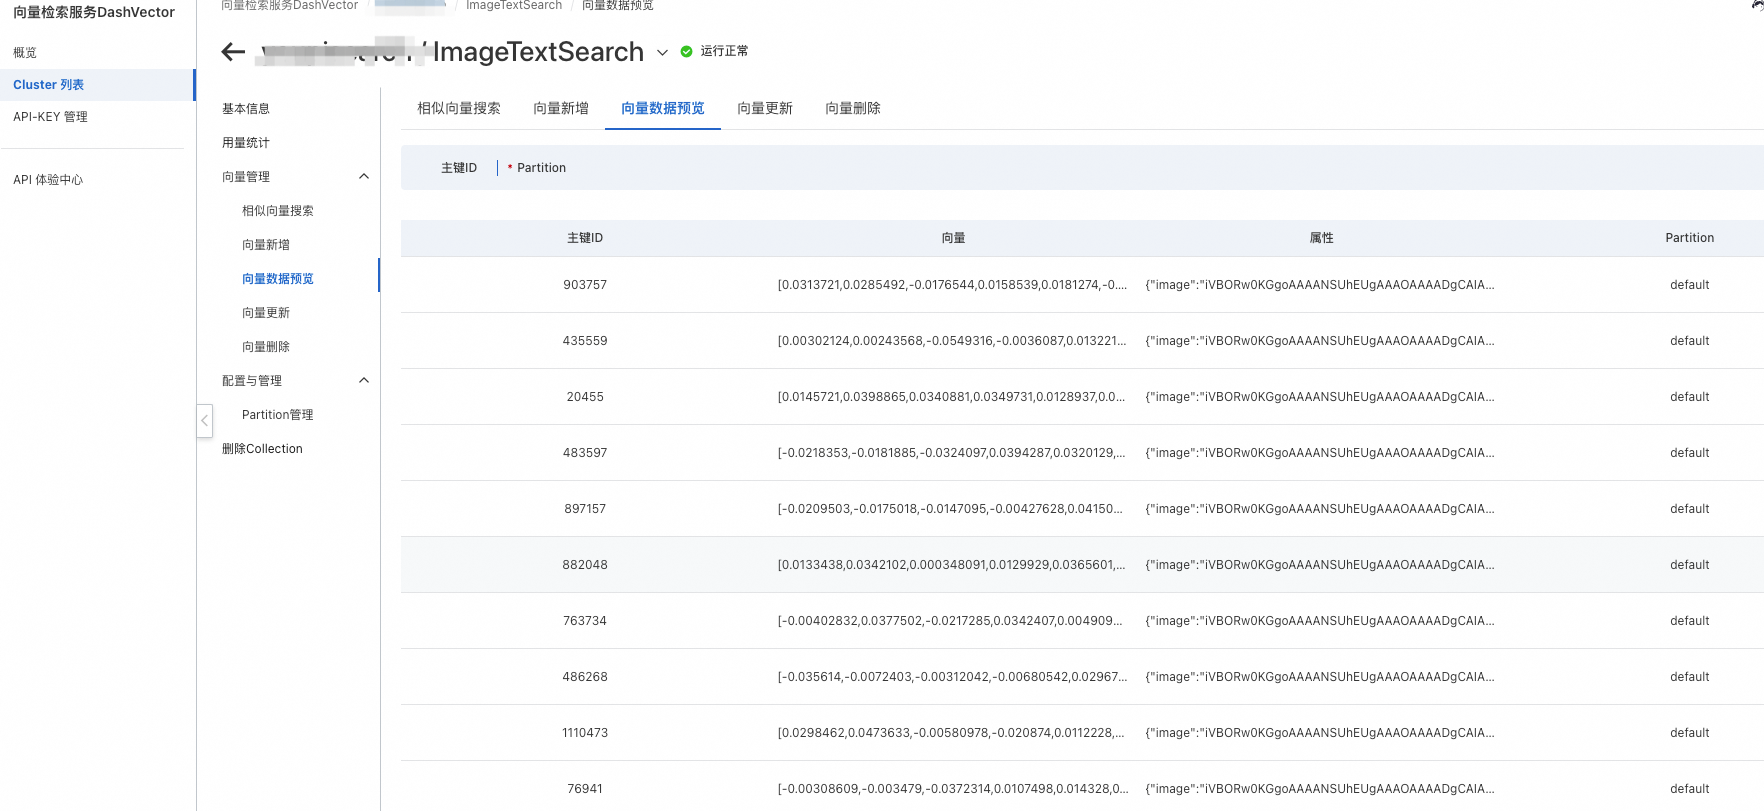

# 4 图片和文本搜索
1. 图片插入成功后，即可进行图片和文本的跨模态搜索了，同样由于搜索过程中，涉及到图片特征提取，建议使用GPU进行。

In [ ]:
# 老规矩，先import一堆东西
from modelscope.utils.constant import Tasks
from modelscope.preprocessors.image import load_image
from modelscope.pipelines import pipeline
from PIL import Image
import base64
import io
from dashvector import Client, Doc, DashVectorCode, DashVectorException
from dashtext import SparseVectorEncoder, combine_dense_and_sparse
from urllib.parse import urlparse



In [ ]:
# 初始化ModelScope推理pipeline，本教程使用Chinese Clip作为embedding模型。由于图片的Embedding比较消耗计算资源，所以推荐使用GPU进行推理加速。
# 请参考：https://modelscope.cn/models/iic/multi-modal_clip-vit-huge-patch14_zh/summary
pipeline = pipeline(task=Tasks.multi_modal_embedding,
                    model='damo/multi-modal_clip-vit-huge-patch14_zh', model_revision='v1.0.0')



In [ ]:
# 初始化稀疏向量编码器，用于对muge数据集中的query进行稀疏向量编码，中文编码。详情请参考：https://help.aliyun.com/document_detail/2546039.html
encoder = SparseVectorEncoder()
# encoder初始化的时间比较长，主要原因在于稀疏向量编码器需要加载一个json文件，该文件比较大，需要下载。我们可以先下载完，保存在本地，直接加载，速度会快很多。
# 下载链接：https://dashvector-data.oss-cn-beijing.aliyuncs.com/public/sparsevector/bm25_zh_default.json
# 也可以使用：wget https://dashvector-data.oss-cn-beijing.aliyuncs.com/public/sparsevector/bm25_zh_default.json，直接下载到本地。
# 下载完成后，放在本机目录中，本教程已经下载完成，放在根目录下。
encoder_path = 'bm25_zh_default.json'
encoder.load(encoder_path)



In [ ]:
# 如下填写您在1.2 准备工作中获取的DashVector API-KEY
DASHVECTOR_API_KEY = '{YOUR DashVector API-KEY}'
# 如下填写您在1.2 准备工作中获取的DashVector中Cluster中的Endpoint
DASHVECTOR_END_POINT = '{YOUR DashVector Endpoint}'

# 初始化dashvector的Client，用于访问dashvector服务
# 请参考：https://help.aliyun.com/document_detail/2510240.html
client = Client(api_key=DASHVECTOR_API_KEY, endpoint=DASHVECTOR_END_POINT)



In [ ]:
# 将字符串转为图片
def str2image(image_str):
    image_bytes = base64.b64decode(image_str)
    return Image.open(io.BytesIO(image_bytes))


# 判断是否为URL
def is_url(url):
    try:
        result = urlparse(url)
        return all([result.scheme, result.netloc])
    except ValueError:
        return False


# 通过Chinese Clip提取图片特征，并转成向量
def image_vector(image):
    # 通过Chinese Clip提取图片特征，返回为一个tensor
    img_embedding = pipeline.forward({'img': image})['img_embedding']
    # 将返回的tensor转成向量,向量需要转存到cpu中
    img_vector = img_embedding.detach().cpu().numpy()
    return img_vector if isinstance(image, list) else img_vector[0]


# 通过Chinese Clip提取文本特征，并转成向量
def text_vector(text):
    # 通过Chinese Clip提取文本特征，返回为一个tensor
    text_embedding = pipeline.forward({'text': text})['text_embedding']
    # 将返回的tensor转成向量,向量需要转存到cpu中
    text_vector = text_embedding.detach().cpu().numpy()
    return text_vector if isinstance(text, list) else text_vector[0]


# 通过dashtext对文本生成稀疏向量。注意，本函数为query的稀疏向量，而不是入库的稀疏向量
def sparse_vector_queries(text):
    # 通过dashtext生成稀疏向量
    sparse_vector = encoder.encode_queries(text)
    return sparse_vector if isinstance(text, list) else sparse_vector


# 通过文本和图片搜索图片，返回搜索结果。其中，文本会转换为稀疏向量，图片会转换成稠密向量，并通过alpha值控制稠密向量和稀疏向量的权重，alpha=1.0则全部使用稠密向量搜索，alpha=0.0则全部使用稀疏向量搜索
def serach_by_imageAndtext(query_text, query_image, collection_name, partition='default', top_k=10, alpha=0.5):
    if is_url(query_image):
        query_image = load_image(query_image)
    image_embedding = image_vector(query_image)
    query_sparse_embedding = sparse_vector_queries(query_text)
    scaled_dense_vector, scaled_sparse_vector = combine_dense_and_sparse(image_embedding, query_sparse_embedding, alpha)
    try:
        collection = client.get(name=collection_name)
        # 搜索
        docs = collection.query(
            vector=scaled_dense_vector,
            sparse_vector=scaled_sparse_vector,
            partition=partition,
            topk=top_k,
            output_fields=['image', 'query', 'image_id']
        )

        image_list = list()
        for doc in docs:
            image_str = doc.fields['image']
            print(doc.score)
            # print(doc.fields['query'])
            # print(doc.fields['image_id'])
            image_list.append(str2image(image_str))
        return image_list

    except DashVectorException as e:
        print(e)
        return []


# 通过文本搜索图片，返回搜索结果，并将文本变成对应的稀疏向量和稠密向量，稀疏向量用来控制文本中是否包含该关键词，稠密向量用于控制图片中是否包含此信息。可通过alpha值控制稠密向量和稀疏向量的权重，alpha=1.0则全部使用稠密向量搜索，alpha=0.0则全部使用稀疏向量搜索
def search_by_text(query_text, collection_name, partition='default', top_k=10, alpha=0.5):
    query_embedding = text_vector(query_text)
    query_sparse_embedding = sparse_vector_queries(query_text)
    scaled_dense_vector, scaled_sparse_vector = combine_dense_and_sparse(query_embedding, query_sparse_embedding, alpha)
    try:
        collection = client.get(name=collection_name)
        # 搜索
        docs = collection.query(
            vector=scaled_dense_vector,
            sparse_vector=scaled_sparse_vector,
            partition=partition,
            topk=top_k,
            output_fields=['image', 'query', 'image_id']
        )

        image_list = list()
        for doc in docs:
            image_str = doc.fields['image']
            print(doc.score)
            # print(doc.fields['query'])
            # print(doc.fields['image_id'])
            image_list.append(str2image(image_str))
        return image_list

    except DashVectorException as e:
        print(e)
        return []



In [ ]:
if __name__ == '__main__':
    query_text = '女士帽子'
    query_image = 'https://viapi-aistore-2.oss-cn-shanghai.aliyuncs.com/dashvector/O1CN01XjQLIb2JjMX6sVhn7_!!2217497569457-0-cib.jpg?OSSAccessKeyId=LTAI5tLRnkQsKsPDmaEqcFnA&Expires=2072648960&Signature=%2BR9ntAyvmylLUXeYxgmJ8ur03WE%3D'
    # response = search_by_text(query_text=query_text, collection_name='ImageTextSearch', alpha=0.5,top_k=20)
    response = serach_by_imageAndtext(query_text=query_text, query_image=query_image, collection_name='ImageTextSearch',
                                      top_k=20, alpha=0.8)
    for image in response:
        display(image)



2. 搜索结果出来啦！

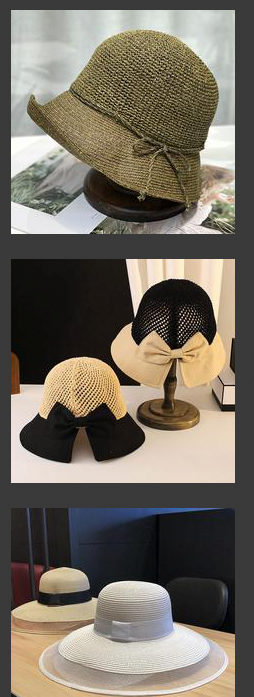